In [1]:
import numpy as np
import open3d as o3d
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import copy

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


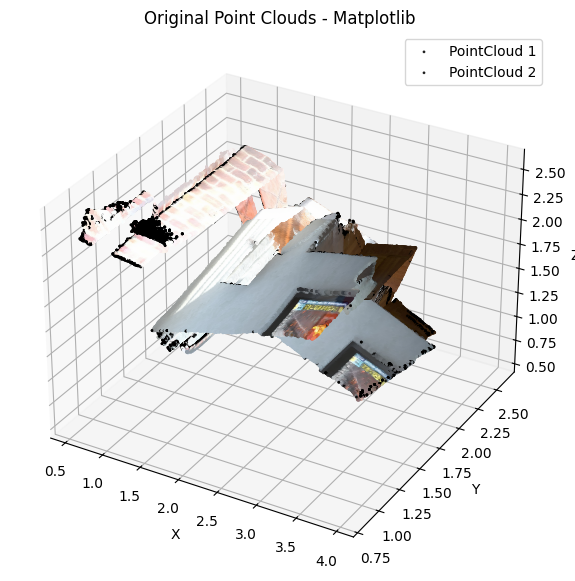

In [2]:

def visualize_point_clouds_matplotlib(pcd_list, title="Point Clouds"):
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')
    
    for i, pcd in enumerate(pcd_list):
        points = np.asarray(pcd.points)
        
        # Use point cloud colors if available, else use a default color
        if pcd.has_colors():
            colors = np.asarray(pcd.colors)
        else:
            colors = np.array([[1, 0, 0]])  # red as fallback
            colors = np.tile(colors, (points.shape[0], 1))
        
        ax.scatter(points[:, 0], points[:, 1], points[:, 2], 
                   c=colors, s=1, label=f'PointCloud {i+1}', alpha=0.8)
    
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title(title)
    ax.legend()
    plt.show()
 
#  dataset
dataset = o3d.data.DemoICPPointClouds()
pcd0 = o3d.io.read_point_cloud(dataset.paths[0])
pcd1 = o3d.io.read_point_cloud(dataset.paths[1])

# Paint colors since none are present
if not pcd0.has_colors():
    pcd0.paint_uniform_color([1, 0, 0])  # red
if not pcd1.has_colors():
    pcd1.paint_uniform_color([0, 1, 0])  # green

visualize_point_clouds_matplotlib([pcd0, pcd1], "Original Point Clouds - Matplotlib")


## 3. Visualization of Point Clouds
- **Function: `visualize_point_clouds_matplotlib()`**
  - Displays multiple point clouds in 3D using Matplotlib.
  - Colors are used if available; otherwise defaults to red.
  
- **Function: `visualize_point_clouds()`**
  - Shows side-by-side comparison:
    - Source point cloud
    - Target point cloud
    - Overlapped view with transparency for alignment inspection.

In [3]:
def visualize_point_clouds(pcd1, pcd2, title="Point Clouds"):
    """
    Visualize two point clouds using matplotlib with better overlap visualization
    """
    points1 = np.asarray(pcd1.points)
    points2 = np.asarray(pcd2.points)
    colors1 = np.asarray(pcd1.colors)
    colors2 = np.asarray(pcd2.colors)
    
    # Create side-by-side comparison
    fig = plt.figure(figsize=(20, 8))
    
    # Individual point clouds
    ax1 = fig.add_subplot(131, projection='3d')
    ax1.scatter(points1[:, 0], points1[:, 1], points1[:, 2], 
               c='red', s=20, alpha=0.6, label='Source')
    ax1.set_xlabel('X'); ax1.set_ylabel('Y'); ax1.set_zlabel('Z')
    ax1.set_title('Source Point Cloud (Red)')
    ax1.legend()
    
    ax2 = fig.add_subplot(132, projection='3d')
    ax2.scatter(points2[:, 0], points2[:, 1], points2[:, 2], 
               c='blue', s=20, alpha=0.6, label='Target')
    ax2.set_xlabel('X'); ax2.set_ylabel('Y'); ax2.set_zlabel('Z')
    ax2.set_title('Target Point Cloud (Blue)')
    ax2.legend()
    
    # Overlapped view with better transparency
    ax3 = fig.add_subplot(133, projection='3d')
    ax3.scatter(points1[:, 0], points1[:, 1], points1[:, 2], 
               c='red', s=15, alpha=0.4, label='Source')
    ax3.scatter(points2[:, 0], points2[:, 1], points2[:, 2], 
               c='blue', s=15, alpha=0.4, label='Target')
    ax3.set_xlabel('X'); ax3.set_ylabel('Y'); ax3.set_zlabel('Z')
    ax3.set_title(f'Overlap View - {title}')
    ax3.legend()
    
    # Make all plots have the same scale
    all_points = np.vstack([points1, points2])
    for ax in [ax1, ax2, ax3]:
        ax.set_xlim([all_points[:, 0].min(), all_points[:, 0].max()])
        ax.set_ylim([all_points[:, 1].min(), all_points[:, 1].max()])
        ax.set_zlim([all_points[:, 2].min(), all_points[:, 2].max()])
    
    plt.tight_layout()
    plt.show()

##  Registration Quality Evaluation
- **Function: `visualize_registration_quality()`**
  - Compare alignment before and after registration.
  - Metrics and plots:
    - 3D scatter plots (before/after).
    - Histograms of nearest-neighbor distances.
    - Statistical summary (mean, std, max distance).
    - Distance heatmap (2D projection).
    - Improvement metrics:
      - Mean distance reduction
      - Percentage of points within error thresholds
      - Overall registration quality rating.

In [4]:
def visualize_registration_quality(source, target, transformed_target, title="Registration Quality"):
    """
    Visualize registration quality with distance heatmap and alignment metrics
    """
    fig = plt.figure(figsize=(20, 12))
    
    source_points = np.asarray(source.points)
    target_points = np.asarray(target.points)
    transformed_points = np.asarray(transformed_target.points)
    
    # Before registration
    ax1 = fig.add_subplot(231, projection='3d')
    ax1.scatter(source_points[:, 0], source_points[:, 1], source_points[:, 2], 
               c='red', s=15, alpha=0.5, label='Source')
    ax1.scatter(target_points[:, 0], target_points[:, 1], target_points[:, 2], 
               c='blue', s=15, alpha=0.5, label='Target')
    ax1.set_title('Before Registration')
    ax1.legend()
    
    # After registration
    ax2 = fig.add_subplot(232, projection='3d')
    ax2.scatter(source_points[:, 0], source_points[:, 1], source_points[:, 2], 
               c='red', s=15, alpha=0.5, label='Source')
    ax2.scatter(transformed_points[:, 0], transformed_points[:, 1], transformed_points[:, 2], 
               c='blue', s=15, alpha=0.5, label='Transformed Target')
    ax2.set_title('After Registration')
    ax2.legend()
    
    # Compute distances for quality assessment
    from sklearn.neighbors import NearestNeighbors
    
    # Find nearest neighbor distances
    nn = NearestNeighbors(n_neighbors=1)
    nn.fit(source_points)
    distances_before, _ = nn.kneighbors(target_points)
    distances_after, _ = nn.kneighbors(transformed_points)
    
    # Distance histograms
    ax3 = fig.add_subplot(233)
    ax3.hist(distances_before.flatten(), bins=50, alpha=0.7, label='Before Registration', color='red')
    ax3.hist(distances_after.flatten(), bins=50, alpha=0.7, label='After Registration', color='blue')
    ax3.set_xlabel('Distance to Nearest Point')
    ax3.set_ylabel('Frequency')
    ax3.set_title('Distance Distribution')
    ax3.legend()
    ax3.set_yscale('log')
    
    # Distance statistics
    ax4 = fig.add_subplot(234)
    stats_data = [
        ['Mean Distance Before', np.mean(distances_before)],
        ['Mean Distance After', np.mean(distances_after)],
        ['Std Distance Before', np.std(distances_before)],
        ['Std Distance After', np.std(distances_after)],
        ['Max Distance Before', np.max(distances_before)],
        ['Max Distance After', np.max(distances_after)]
    ]
    
    table = ax4.table(cellText=[[f'{row[0]}', f'{row[1]:.4f}'] for row in stats_data],
                     colLabels=['Metric', 'Value'],
                     cellLoc='left',
                     loc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1, 2)
    ax4.axis('off')
    ax4.set_title('Registration Statistics')
    
    # Color-coded distance visualization (2D projection)
    ax5 = fig.add_subplot(235)
    scatter = ax5.scatter(transformed_points[:, 0], transformed_points[:, 1], 
                         c=distances_after.flatten(), cmap='viridis', s=10, alpha=0.7)
    ax5.scatter(source_points[:, 0], source_points[:, 1], 
               c='red', s=5, alpha=0.3, label='Source')
    plt.colorbar(scatter, ax=ax5, label='Distance to Nearest Source Point')
    ax5.set_xlabel('X'); ax5.set_ylabel('Y')
    ax5.set_title('Distance Heatmap (XY Projection)')
    ax5.legend()
    
    # Improvement metrics
    ax6 = fig.add_subplot(236)
    improvement_metrics = [
        f"Mean Distance Reduction: {((np.mean(distances_before) - np.mean(distances_after)) / np.mean(distances_before) * 100):.2f}%",
        f"Std Reduction: {((np.std(distances_before) - np.std(distances_after)) / np.std(distances_before) * 100):.2f}%",
        f"Points within 0.01 units: {np.sum(distances_after < 0.01)} / {len(distances_after)}",
        f"Points within 0.05 units: {np.sum(distances_after < 0.05)} / {len(distances_after)}",
        f"Registration Quality: {'Excellent' if np.mean(distances_after) < 0.01 else 'Good' if np.mean(distances_after) < 0.05 else 'Fair'}"
    ]
    
    ax6.text(0.1, 0.9, '\n'.join(improvement_metrics), transform=ax6.transAxes, 
             fontsize=12, verticalalignment='top', fontfamily='monospace',
             bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))
    ax6.axis('off')
    ax6.set_title('Registration Quality Metrics')
    
    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()
    
    return distances_before, distances_after

## 🔹 Step 4: Preprocess Point Clouds
Preprocessing steps:
1. Voxel downsampling to reduce point count  
2. Normal estimation to compute surface orientation  
3. FPFH feature extraction for robust matching  


In [5]:

def preprocess_point_clouds(pcd1, pcd2, voxel_size=0.05):
    """
    Preprocess point clouds: downsample, estimate normals, compute features
    """
    print("Preprocessing point clouds...")
    
    # Downsample with voxel filter
    pcd1_down = pcd1.voxel_down_sample(voxel_size)
    pcd2_down = pcd2.voxel_down_sample(voxel_size)
    
    # Estimate normals
    radius_normal = voxel_size * 2
    pcd1_down.estimate_normals(
        o3d.geometry.KDTreeSearchParamHybrid(radius=radius_normal, max_nn=30))
    pcd2_down.estimate_normals(
        o3d.geometry.KDTreeSearchParamHybrid(radius=radius_normal, max_nn=30))
    
    # Compute FPFH features
    radius_feature = voxel_size * 5
    pcd1_fpfh = o3d.pipelines.registration.compute_fpfh_feature(
        pcd1_down,
        o3d.geometry.KDTreeSearchParamHybrid(radius=radius_feature, max_nn=100))
    pcd2_fpfh = o3d.pipelines.registration.compute_fpfh_feature(
        pcd2_down,
        o3d.geometry.KDTreeSearchParamHybrid(radius=radius_feature, max_nn=100))
    
    return pcd1_down, pcd2_down, pcd1_fpfh, pcd2_fpfh


## 5. Registration Quality Evaluation
- **Function: `visualize_registration_quality()`**
  - Compare alignment before and after registration.
  - Metrics and plots:
    - 3D scatter plots (before/after).
    - Histograms of nearest-neighbor distances.
    - Statistical summary (mean, std, max distance).
    - Distance heatmap (2D projection).
    - Improvement metrics:
      - Mean distance reduction
      - Percentage of points within error thresholds
      - Overall registration quality rating.

In [6]:
def execute_global_registration(pcd1, pcd2, pcd1_fpfh, pcd2_fpfh, voxel_size):
    """
    Execute global registration using RANSAC
    """
    print("Performing global registration...")
    
    distance_threshold = voxel_size * 1.5
    result = o3d.pipelines.registration.registration_ransac_based_on_feature_matching(
        pcd1, pcd2, pcd1_fpfh, pcd2_fpfh, True,
        distance_threshold,
        o3d.pipelines.registration.TransformationEstimationPointToPoint(False),
        3, [
            o3d.pipelines.registration.CorrespondenceCheckerBasedOnEdgeLength(0.9),
            o3d.pipelines.registration.CorrespondenceCheckerBasedOnDistance(distance_threshold)
        ], o3d.pipelines.registration.RANSACConvergenceCriteria(100000, 0.999))
    
    return result

## Applying Registration Methods
Two registration methods are applied:
- **Global Registration (RANSAC)** using FPFH features for coarse alignment.
- **Iterative Closest Point (ICP)** for fine alignment refinement.


In [7]:
def execute_icp_registration(pcd1, pcd2, initial_transformation, voxel_size):
    """
    Execute ICP registration with different methods
    """
    print("Performing ICP registration...")
    
    threshold = voxel_size * 0.4
    
    # Point-to-Point ICP
    print("Point-to-Point ICP")
    reg_p2p = o3d.pipelines.registration.registration_icp(
        pcd1, pcd2, threshold, initial_transformation,
        o3d.pipelines.registration.TransformationEstimationPointToPoint())
    
    print(f"Point-to-Point ICP fitness: {reg_p2p.fitness:.4f}")
    print(f"Point-to-Point ICP inlier_rmse: {reg_p2p.inlier_rmse:.4f}")
    
    # Point-to-Plane ICP (more robust)
    print("\nPoint-to-Plane ICP")
    reg_p2l = o3d.pipelines.registration.registration_icp(
        pcd1, pcd2, threshold, initial_transformation,
        o3d.pipelines.registration.TransformationEstimationPointToPlane())
    
    print(f"Point-to-Plane ICP fitness: {reg_p2l.fitness:.4f}")
    print(f"Point-to-Plane ICP inlier_rmse: {reg_p2l.inlier_rmse:.4f}")
    
    return reg_p2p, reg_p2l


In [8]:
def display_transformation_details(transformation):
    """
    Display detailed information about the transformation matrix
    """
    print("\n" + "="*50)
    print("TRANSFORMATION MATRIX ANALYSIS")
    print("="*50)
    print("Transformation Matrix:")
    print(transformation)
    
    # Extract rotation and translation
    R = transformation[:3, :3]
    t = transformation[:3, 3]
    
    print(f"\nTranslation vector: [{t[0]:.4f}, {t[1]:.4f}, {t[2]:.4f}]")
    
    # Calculate rotation angle
    trace_R = np.trace(R)
    angle = np.arccos(np.clip((trace_R - 1) / 2, -1, 1))
    angle_degrees = np.degrees(angle)
    
    print(f"Rotation angle: {angle_degrees:.2f} degrees")
    
    # Calculate rotation axis (for small rotations)
    if angle > 1e-6:
        axis = np.array([R[2,1] - R[1,2], R[0,2] - R[2,0], R[1,0] - R[0,1]]) / (2 * np.sin(angle))
        print(f"Rotation axis: [{axis[0]:.4f}, {axis[1]:.4f}, {axis[2]:.4f}]")

In [12]:
def main(source_pcd, target_pcd):
    """
    Main function to execute the complete ICP registration pipeline
    """
    print("="*60)
    print("ICP REGISTRATION FOR POINT CLOUD ALIGNMENT")
    print("="*60)
    
    # Step 1: Use provided point clouds
    print("\nStep 1: Using provided point clouds...")
    # Color the point clouds for visualization
    source_pcd.paint_uniform_color([1, 0, 0])  # Red for source
    target_pcd.paint_uniform_color([0, 0, 1])  # Blue for target
    
    print(f"Source point cloud: {len(source_pcd.points)} points")
    print(f"Target point cloud: {len(target_pcd.points)} points")
    
    # Visualize original point clouds
    print("\nVisualizing original point clouds...")
    visualize_point_clouds(source_pcd, target_pcd, "Original Point Clouds")
    
    # Step 2: Preprocess point clouds
    voxel_size = 0.02  # Smaller voxel size for real data
    source_down, target_down, source_fpfh, target_fpfh = preprocess_point_clouds(source_pcd, target_pcd, voxel_size)
    print(f"Downsampled source point cloud: {len(source_down.points)} points")
    print(f"Downsampled target point cloud: {len(target_down.points)} points")
    
    # Step 3: Global registration (initial alignment)
    global_result = execute_global_registration(source_down, target_down, source_fpfh, target_fpfh, voxel_size)
    print(f"Global registration fitness: {global_result.fitness:.4f}")
    print(f"Global registration inlier_rmse: {global_result.inlier_rmse:.4f}")
    
    # Apply global transformation and visualize
    target_global = copy.deepcopy(target_pcd)
    target_global.transform(global_result.transformation)
    print("\nVisualizing after global registration...")
    visualize_point_clouds(source_pcd, target_global, "After Global Registration")
    
    # Quality analysis after global registration
    print("\nAnalyzing global registration quality...")
    dist_before_global, dist_after_global = visualize_registration_quality(
        source_pcd, target_pcd, target_global, "Global Registration Quality Analysis")
    
    # Step 4: ICP registration (fine alignment)
    reg_p2p, reg_p2l = execute_icp_registration(source_down, target_down, 
                                               global_result.transformation, voxel_size)
    
    # Step 5: Apply final transformation and visualize results
    print("\n" + "="*40)
    print("FINAL RESULTS")
    print("="*40)
    
    # Use the better result (point-to-plane usually performs better)
    final_transformation = reg_p2l.transformation
    
    # Apply final transformation
    target_final = copy.deepcopy(target_pcd)
    target_final.transform(final_transformation)
    
    # Visualize final result
    print("\nVisualizing final ICP registration result...")
    visualize_point_clouds(source_pcd, target_final, "Final ICP Registration Result")
    
    # Comprehensive quality analysis
    print("\nAnalyzing final ICP registration quality...")
    dist_before_final, dist_after_final = visualize_registration_quality(
        source_pcd, target_pcd, target_final, "Final ICP Registration Quality Analysis")
    
    # Display transformation details
    display_transformation_details(final_transformation)
    
    # Step 6: Combine point clouds
    print("\nCombining point clouds...")
    combined_pcd = source_pcd + target_final
    combined_pcd.paint_uniform_color([0, 1, 0])  # Green for combined cloud
    
    # Visualize combined result
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    combined_points = np.asarray(combined_pcd.points)
    ax.scatter(combined_points[:, 0], combined_points[:, 1], combined_points[:, 2], 
               c='green', s=50, alpha=0.7)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title('Combined Point Cloud After ICP Registration')
    plt.show()
    
    print(f"\nCombined point cloud contains {len(combined_pcd.points)} points")
    print("\nICP Registration completed successfully!")
    
    return source_pcd, target_pcd, target_final, combined_pcd, final_transformation

ICP REGISTRATION FOR POINT CLOUD ALIGNMENT

Step 1: Using provided point clouds...
Source point cloud: 198835 points
Target point cloud: 137833 points

Visualizing original point clouds...


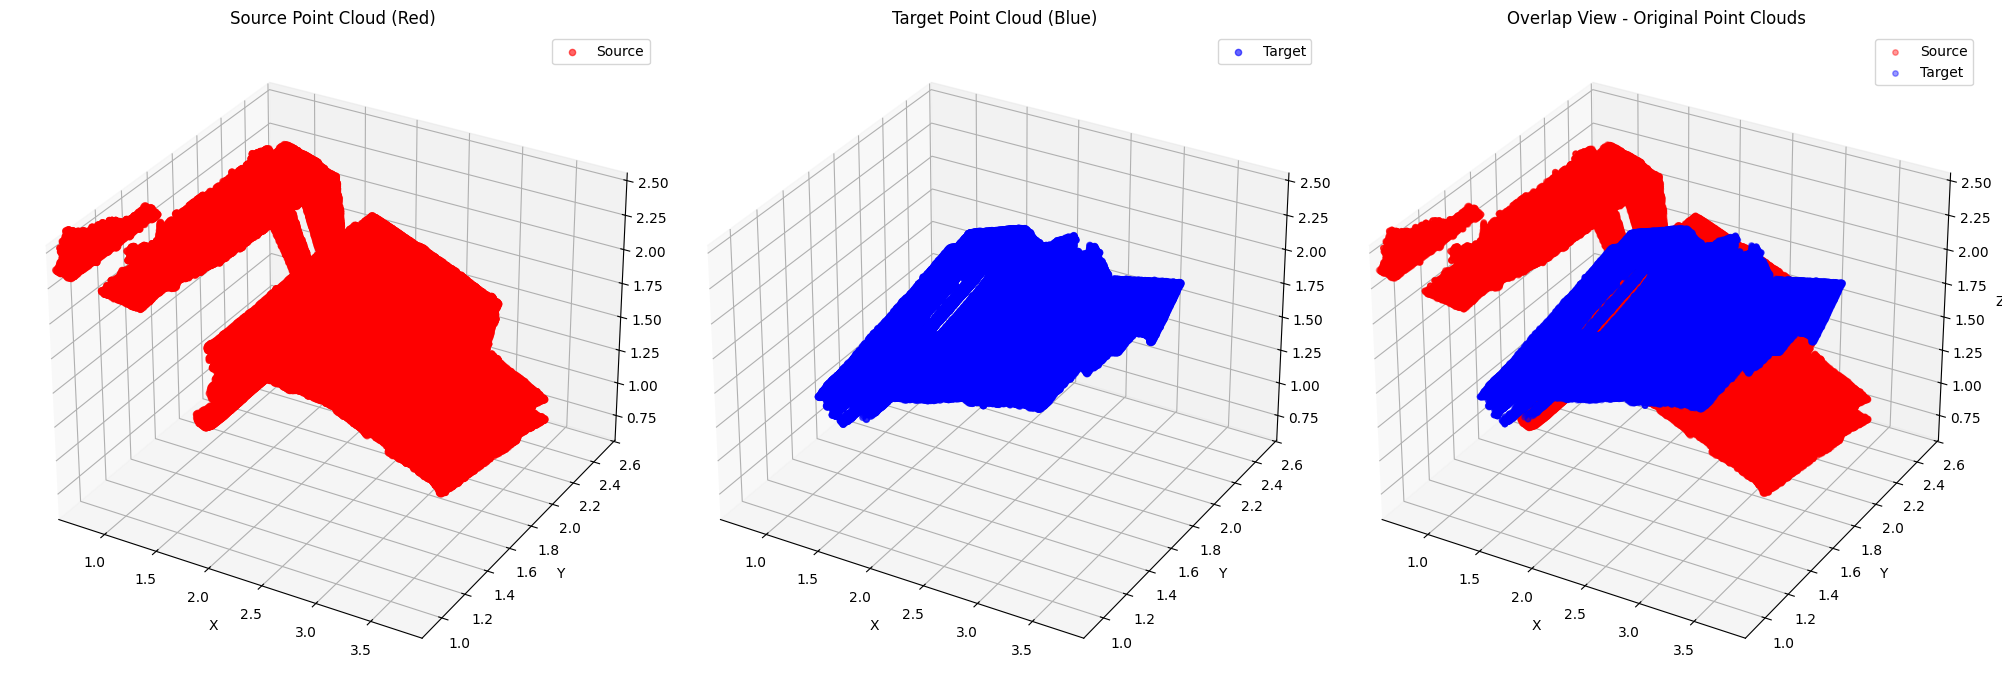

Preprocessing point clouds...
Downsampled source point cloud: 27211 points
Downsampled target point cloud: 19137 points
Performing global registration...
Global registration fitness: 0.6313
Global registration inlier_rmse: 0.0130

Visualizing after global registration...


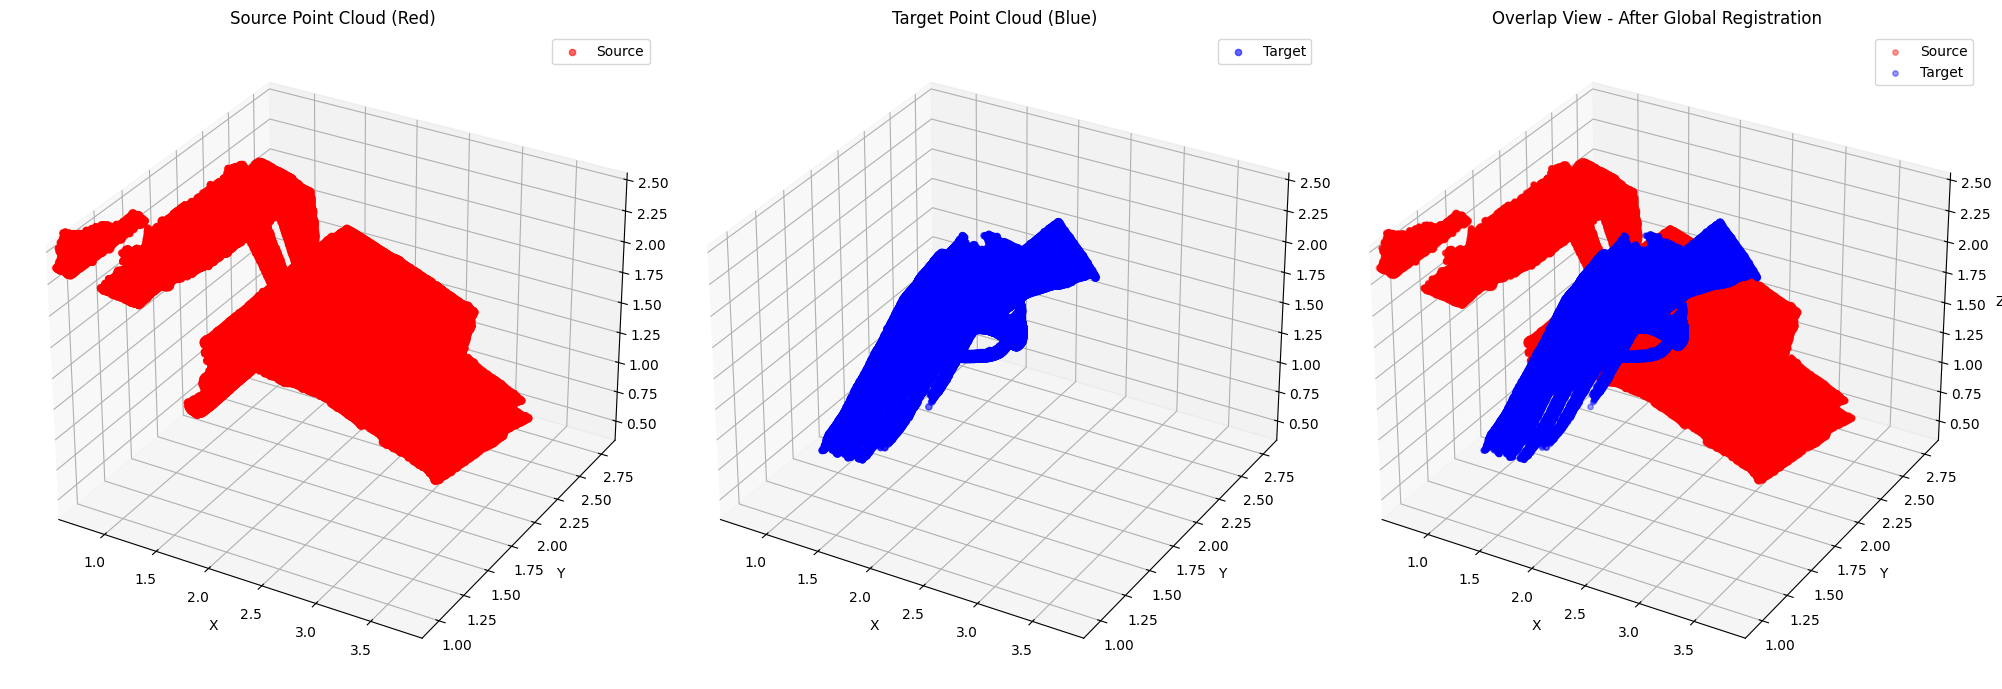


Analyzing global registration quality...


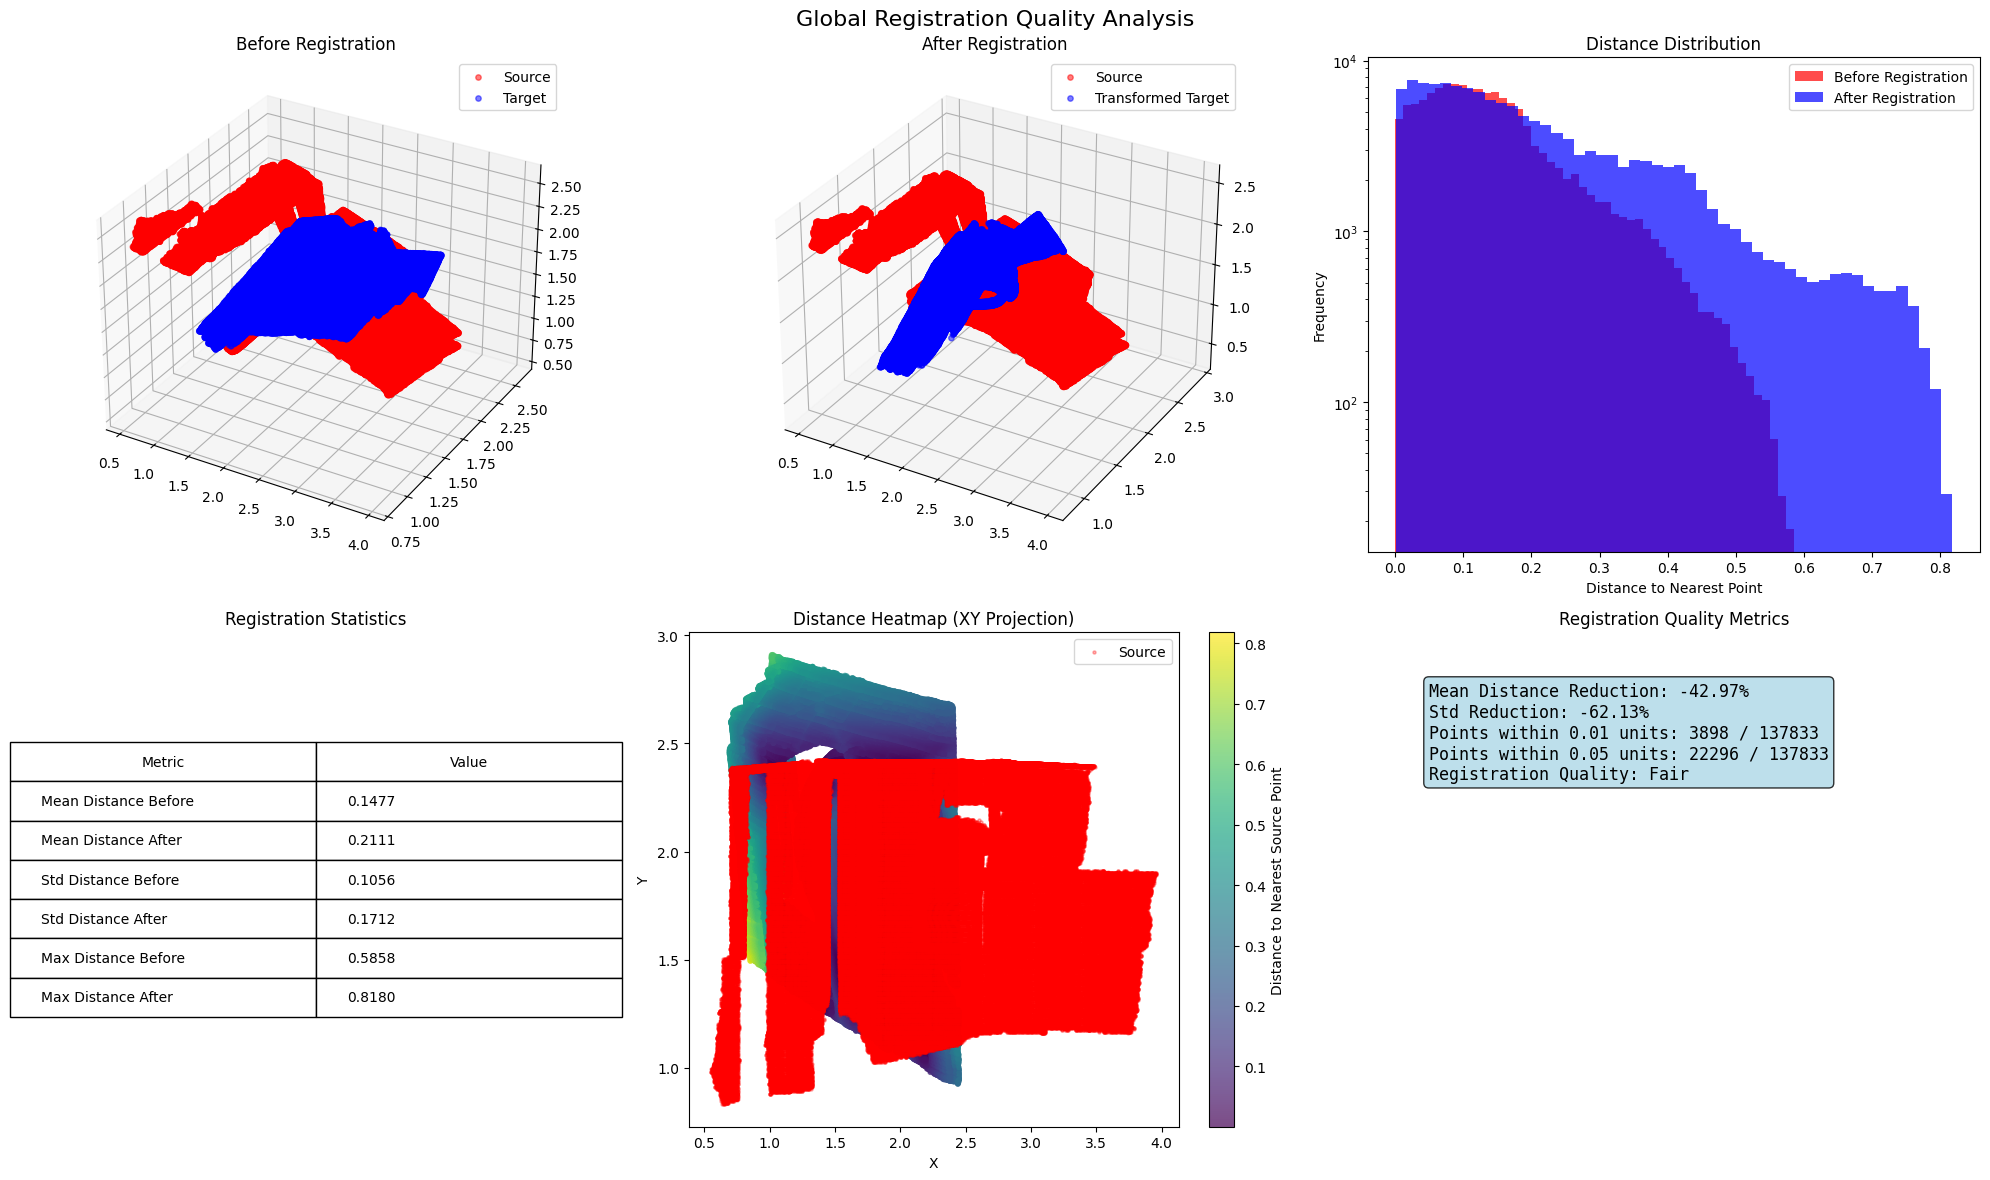

Performing ICP registration...
Point-to-Point ICP
Point-to-Point ICP fitness: 0.2368
Point-to-Point ICP inlier_rmse: 0.0059

Point-to-Plane ICP
Point-to-Plane ICP fitness: 0.2505
Point-to-Plane ICP inlier_rmse: 0.0059

FINAL RESULTS

Visualizing final ICP registration result...


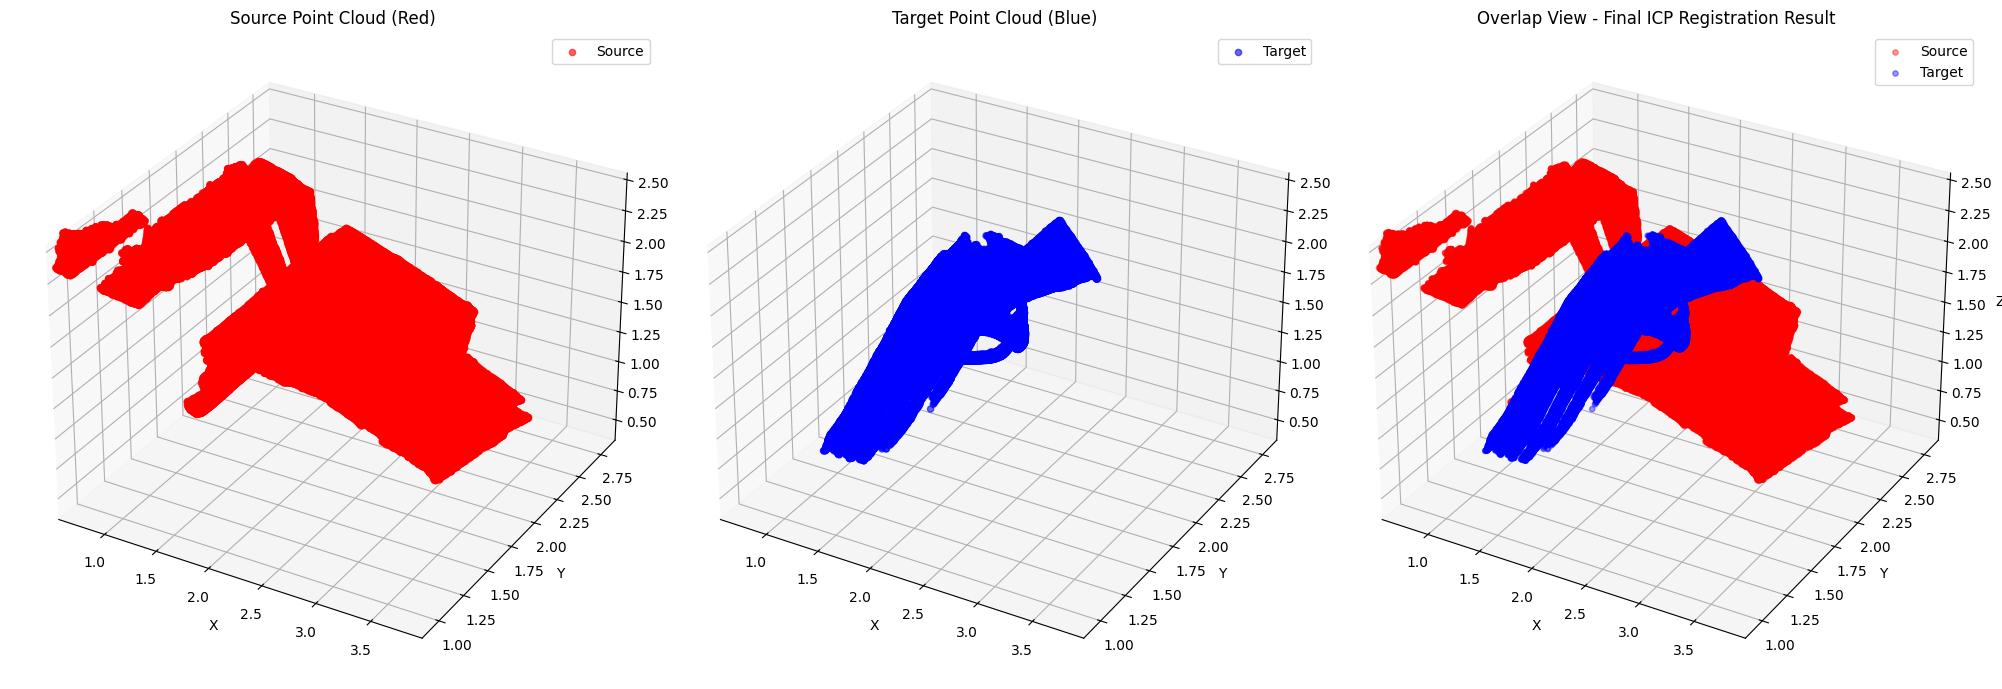


Analyzing final ICP registration quality...


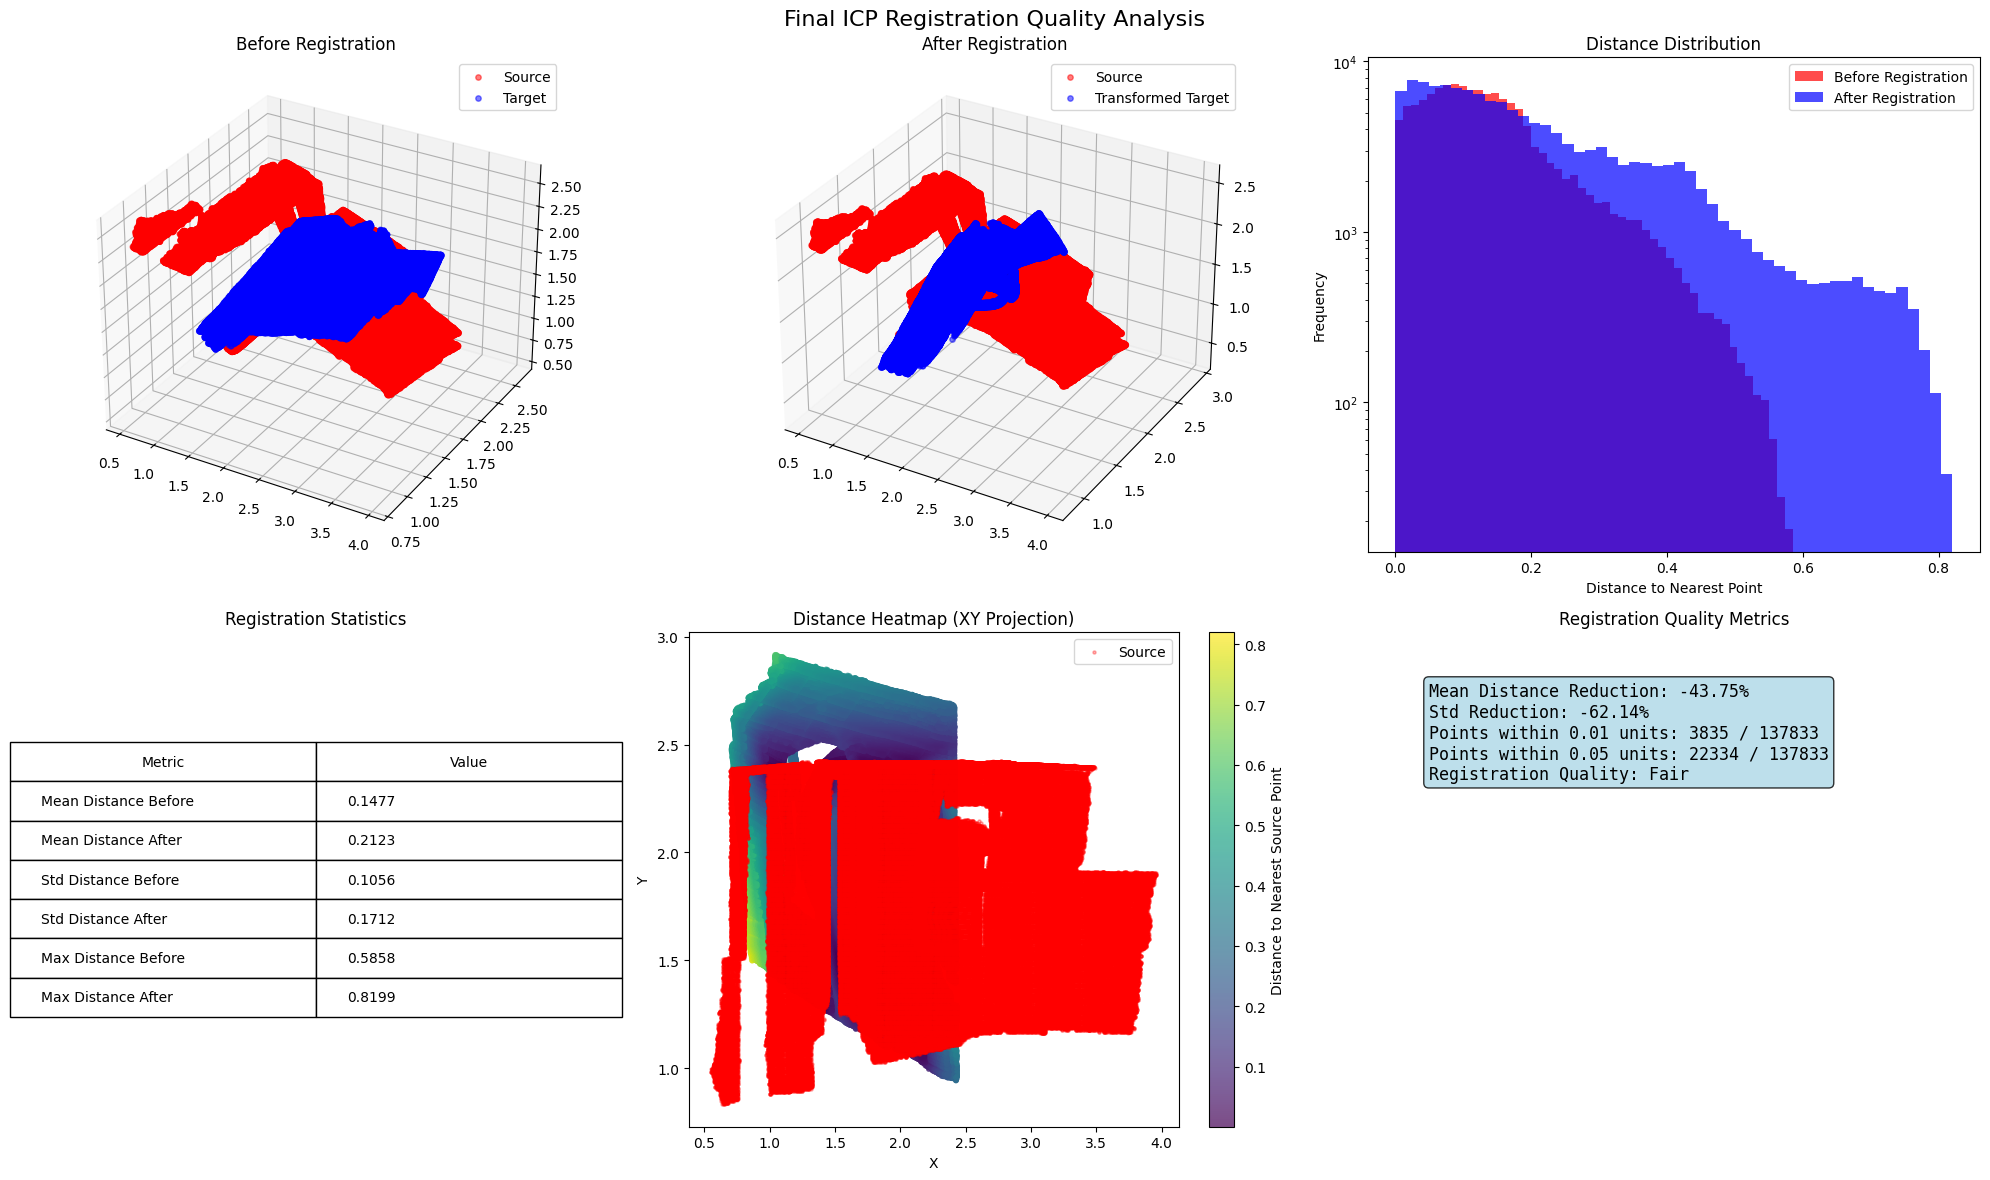


TRANSFORMATION MATRIX ANALYSIS
Transformation Matrix:
[[ 0.83796041  0.00706091 -0.54568534  0.65811635]
 [-0.14658068  0.96608462 -0.21259023  0.79981526]
 [ 0.52567714  0.25812912  0.81057566 -1.48649015]
 [ 0.          0.          0.          1.        ]]

Translation vector: [0.6581, 0.7998, -1.4865]
Rotation angle: 36.17 degrees
Rotation axis: [0.3988, -0.9077, -0.1302]

Combining point clouds...


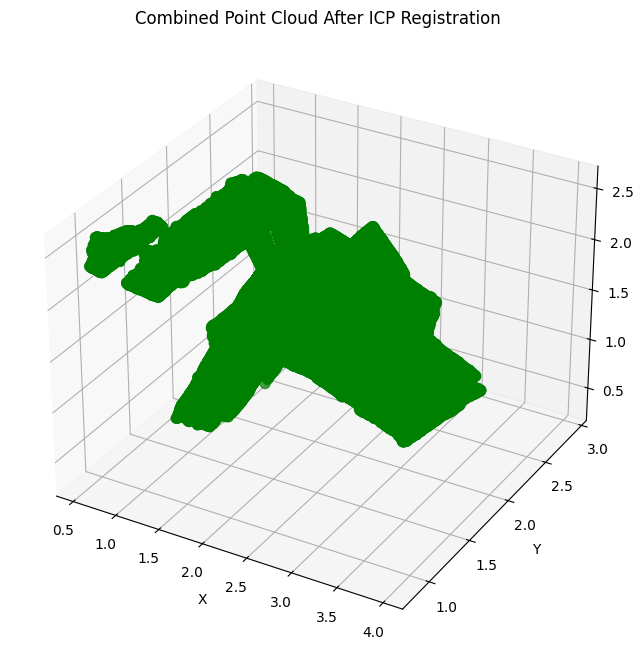


Combined point cloud contains 336668 points

ICP Registration completed successfully!

ICP ALGORITHM EXPLANATION


In [14]:
if __name__ == "__main__":
    dataset = o3d.data.DemoICPPointClouds()
    pcd0 = o3d.io.read_point_cloud(dataset.paths[0])
    pcd1 = o3d.io.read_point_cloud(dataset.paths[1])
    
    # Run the complete ICP registration pipeline with your data
    source, target, registered, combined, transformation = main(pcd0, pcd1)
    
    # Additional analysis
    print("\n" + "="*50)
    print("ICP ALGORITHM EXPLANATION")
    print("="*50)
   

In [17]:

def show_3d(source_pcd, target_pcd, title="3D Overlap"):
    """Simple 3D visualization of overlapped point clouds"""
    # Color point clouds
    source_pcd.paint_uniform_color([1, 0, 0])  # Red
    target_pcd.paint_uniform_color([0, 0, 1])  # Blue
    
    # Show in 3D
    o3d.visualization.draw_geometries([source_pcd, target_pcd], window_name=title)

def show_before_after(source, target, transformation_matrix):
    """Show before and after ICP registration"""
    # Before
    show_3d(source, target, "BEFORE Registration")
    
    # After
    target_reg = copy.deepcopy(target)
    target_reg.transform(transformation_matrix)
    show_3d(source, target_reg, "AFTER Registration")

# Usage:
if __name__ == "__main__":
    # Load data
    dataset = o3d.data.DemoICPPointClouds()
    pcd0 = o3d.io.read_point_cloud(dataset.paths[0])
    pcd1 = o3d.io.read_point_cloud(dataset.paths[1])
    
    # Show overlap
    show_3d(pcd0, pcd1, "Point Cloud Overlap")

[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The requested transformation operation is not supported. 
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The handle is invalid. 
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The requested transformation operation is not supported. 
[Open3D WARNING] [ViewControl] SetViewPoint() failed because window height and width are not set.
